In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

import kassandra as kass

kass.models.set_tf_seed(42)
random_state = np.random.RandomState(seed=42)

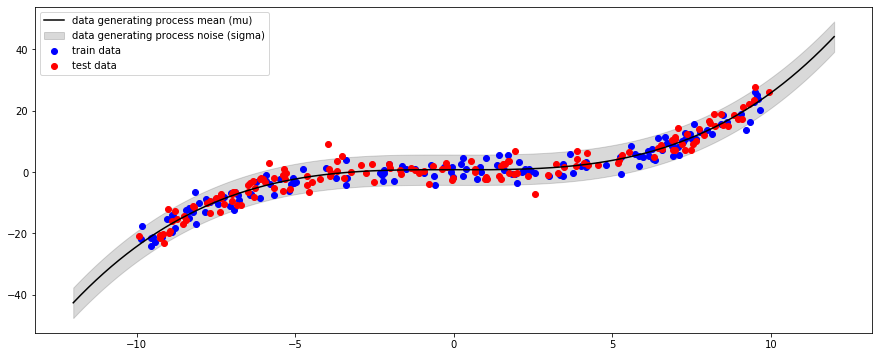

In [2]:
# make data

num_samples = 150
scale_factor = 100

x_train = np.random.uniform(-10, 10, num_samples)
x_train = x_train.reshape(-1, 1)
y_train = x_train**3 - x_train + random_state.normal(0, 100, num_samples).reshape(-1, 1) 

x_test = np.random.uniform(-10, 10, num_samples)
x_test = x_test.reshape(-1, 1)
y_test = x_test**3 - x_test + random_state.normal(0, 100, num_samples).reshape(-1, 1)

feature_space = np.linspace(-12, 12, 1000).reshape(-1, 1)
y_true = feature_space**3 - feature_space

# scale data (best practice for good results)

y_train_mean = y_train.mean()
y_train_std = y_train.std()

scale = 10.0
y_train = scale * (y_train - y_train_mean) / y_train_std
y_test = scale * (y_test - y_train_mean) / y_train_std
y_true = scale * (y_true - y_train_mean) / y_train_std

# plot data

train_color = "b"
test_color = "r"

plt.figure(figsize=(15, 6))
plt.plot(feature_space[:, 0], y_true, c="k", label="data generating process mean (mu)")
plt.fill_between(feature_space[:, 0],
    y_true[:, 0] + 1.96 * scale * 100 / y_train_std, 
    y_true[:, 0] - 1.96 * scale * 100 / y_train_std,
    color="k", alpha=0.15, label="data generating process noise (sigma)"
)
plt.scatter(x_train[:, 0], y_train[:, 0], c=train_color, label="train data")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.legend()
plt.show()

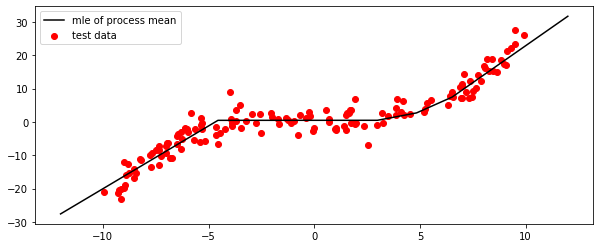

In [3]:
# MLP (epistemic - No, Aleatoric - No)

model = kass.models.MLEMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=False,
    heteroskedastic=False,
    known_aleatoric_variance=None,
    regularization="l2",
    weight_initializer="glorot_normal"
    )

model.fit(x_train, y_train, epochs=500)
mle_mu = model.predict(feature_space).numpy()

# plot data

plt.figure(figsize=(10, 4))
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], mle_mu[:, 0], c="k", label="mle of process mean")
plt.legend()
plt.show()

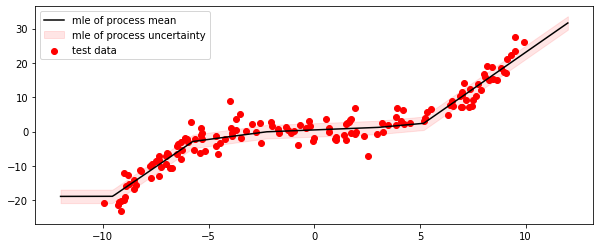

In [4]:
# MLP (epistemic - No, Aleatoric - Known)

model = kass.models.MLEMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=True,
    heteroskedastic=False,
    known_aleatoric_variance=1.0,
    regularization="l2",
    weight_initializer="glorot_normal"
    )

model.fit(x_train, y_train, epochs=500)
mle = model.predict(feature_space)
mle_mu = mle.mean().numpy().reshape(-1, 1)
mle_sigma = mle.stddev().numpy().reshape(-1, 1)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 mle_mu[:, 0] + 1.96*mle_sigma[:, 0],
                 mle_mu[:, 0] - 1.96*mle_sigma[:, 0], 
                 color="r", alpha=0.1, label="mle of process uncertainty")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], mle_mu[:, 0], c="k", label="mle of process mean")
plt.legend()
plt.show()

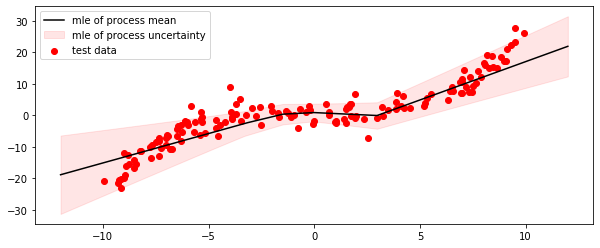

In [5]:
# MLP (epistemic - No, Aleatoric - Unknown)

model = kass.models.MLEMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=True,
    heteroskedastic=True,
    known_aleatoric_variance=None,
    regularization="l2",
    weight_initializer="glorot_normal"
    )

model.fit(x_train, y_train, epochs=500)
mle = model.predict(feature_space)
mle_mu = mle.mean().numpy().reshape(-1, 1)
mle_sigma = mle.stddev().numpy().reshape(-1, 1)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 mle_mu[:, 0] + 1.96*mle_sigma[:, 0],
                 mle_mu[:, 0] - 1.96*mle_sigma[:, 0], 
                 color="r", alpha=0.1, label="mle of process uncertainty")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], mle_mu[:, 0], c="k", label="mle of process mean")
plt.legend()
plt.show()

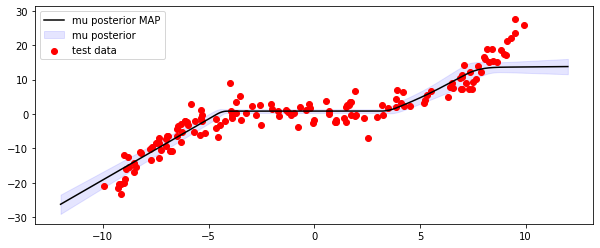

In [6]:
# MLP (epistemic - VI, Aleatoric - No)

model = kass.models.VIMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=False,
    heteroskedastic=False,
    known_aleatoric_variance=None,
    variational_distribution="independant_gaussians",
    prior_distribution="independant_gaussians",
    prior_parameters={"mu": 0.0, "std": 1.0},
    kl_use_exact=True,
    fixed_batch_size=None
    )

model.fit(x_train, y_train, epochs=500)
num_samples = 100
posterior_mu = np.asarray([model.sample_posterior(feature_space).numpy() for _ in range(num_samples)])[:, :, 0].T
posterior_mu_mean = posterior_mu.mean(axis=1).reshape(-1, 1)
posterior_mu_std = posterior_mu.std(axis=1).reshape(-1, 1)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_mu_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_mu_std[:, 0], color="b", 
                 alpha=0.1, label="mu posterior")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], posterior_mu_mean[:, 0], c="k", label="mu posterior MAP")
plt.legend()
plt.show()

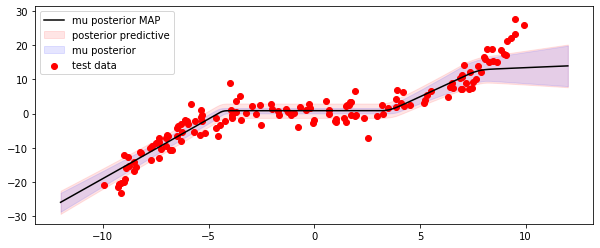

In [7]:
# MLP (epistemic - VI, Aleatoric - Known)

model = kass.models.VIMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=True,
    heteroskedastic=False,
    known_aleatoric_variance=1.0,
    variational_distribution="independant_gaussians",
    prior_distribution="independant_gaussians",
    prior_parameters={"mu": 0.0, "std": 1.0},
    kl_use_exact=True,
    fixed_batch_size=None
    )

model.fit(x_train, y_train, epochs=500)
num_samples = 100
posterior = [model.sample_posterior(feature_space) for _ in range(num_samples)]

posterior_mu = np.asarray([_.mean().numpy() for _ in posterior])
posterior_sigma = np.asarray([_.stddev().numpy() for _ in posterior])

posterior_mu_mean = posterior_mu.mean(axis=0).reshape(-1, 1)
posterior_mu_std = posterior_mu.std(axis=0).reshape(-1, 1)
posterior_sigma_mean = posterior_sigma.mean(axis=0).reshape(-1, 1)
posterior_sigma_std = posterior_sigma.std(axis=0).reshape(-1, 1)

# we're cheating by using the MAP estimate of sigma 
# to find the posterior predictive uncertainty
posterior_predictive_std = np.sqrt(posterior_mu_std**2 + posterior_sigma_mean**2)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_predictive_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_predictive_std[:, 0], color="r", 
                 alpha=0.1, label="posterior predictive")
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_mu_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_mu_std[:, 0], color="b", 
                 alpha=0.1, label="mu posterior")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], posterior_mu_mean[:, 0], c="k", label="mu posterior MAP")
plt.legend()
plt.show()

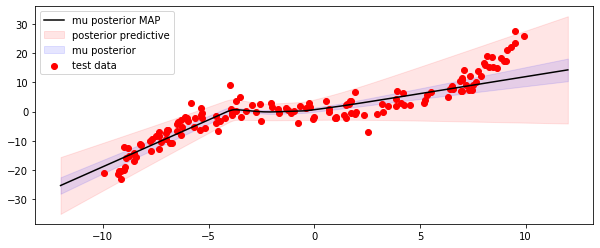

In [8]:
# MLP (epistemic - VI, Aleatoric - Unknown)

model = kass.models.VIMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.01,
    regression=True,
    output_dim=1,
    aleatoric=True,
    heteroskedastic=True,
    known_aleatoric_variance=None,
    variational_distribution="independant_gaussians",
    prior_distribution="independant_gaussians",
    prior_parameters={"mu": 0.0, "std": 1.0},
    kl_use_exact=True,
    fixed_batch_size=y_train.shape[0]
    )

model.fit(x_train, y_train, epochs=10000)
num_samples = 100
posterior = [model.sample_posterior(feature_space) for _ in range(num_samples)]

posterior_mu = np.asarray([_.mean().numpy() for _ in posterior])
posterior_sigma = np.asarray([_.stddev().numpy() for _ in posterior])

posterior_mu_mean = posterior_mu.mean(axis=0).reshape(-1, 1)
posterior_mu_std = posterior_mu.std(axis=0).reshape(-1, 1)
posterior_sigma_mean = posterior_sigma.mean(axis=0).reshape(-1, 1)
posterior_sigma_std = posterior_sigma.std(axis=0).reshape(-1, 1)

# we're cheating by using the MAP estimate of sigma 
# to find the posterior predictive uncertainty
posterior_predictive_std = np.sqrt(posterior_mu_std**2 + posterior_sigma_mean**2)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_predictive_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_predictive_std[:, 0], color="r", 
                 alpha=0.1, label="posterior predictive")
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_mu_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_mu_std[:, 0], color="b", 
                 alpha=0.1, label="mu posterior")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], posterior_mu_mean[:, 0], c="k", label="mu posterior MAP")
plt.legend()
plt.show()

In [ ]:
# MLP (epistemic - DVIF, Aleatoric - No)

model = kass.models.DVIFMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=False,
    heteroskedastic=False,
    known_aleatoric_variance=None
    )

model.fit(x_train, y_train, epochs=5000)
num_samples = 100
posterior_mu = np.asarray([model.sample_posterior(feature_space).numpy() for _ in range(num_samples)])[:, :, 0].T
posterior_mu_mean = posterior_mu.mean(axis=1).reshape(-1, 1)
posterior_mu_std = posterior_mu.std(axis=1).reshape(-1, 1)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_mu_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_mu_std[:, 0], color="b", 
                 alpha=0.1, label="mu posterior")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], posterior_mu_mean[:, 0], c="k", label="mu posterior MAP")
plt.legend()
plt.show()

In [ ]:
# MLP (epistemic - DVIF, Aleatoric - Known)

model = kass.models.DVIFMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.01,
    regression=True,
    output_dim=1,
    aleatoric=True,
    heteroskedastic=False,
    known_aleatoric_variance=1.0
    )

model.fit(x_train, y_train, epochs=10000)
num_samples = 100
posterior = [model.sample_posterior(feature_space) for _ in range(num_samples)]

posterior_mu = np.asarray([_.mean().numpy() for _ in posterior])
posterior_sigma = np.asarray([_.stddev().numpy() for _ in posterior])

posterior_mu_mean = posterior_mu.mean(axis=0).reshape(-1, 1)
posterior_mu_std = posterior_mu.std(axis=0).reshape(-1, 1)
posterior_sigma_mean = posterior_sigma.mean(axis=0).reshape(-1, 1)
posterior_sigma_std = posterior_sigma.std(axis=0).reshape(-1, 1)

# we're cheating by using the MAP estimate of sigma 
# to find the posterior predictive uncertainty
posterior_predictive_std = np.sqrt(posterior_mu_std**2 + posterior_sigma_mean**2)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_predictive_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_predictive_std[:, 0], color="r", 
                 alpha=0.1, label="posterior predictive")
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_mu_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_mu_std[:, 0], color="b", 
                 alpha=0.1, label="mu posterior")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], posterior_mu_mean[:, 0], c="k", label="mu posterior MAP")
plt.legend()
plt.show()

In [ ]:
# MLP (epistemic - DVIF, Aleatoric - Unknown)

model = kass.models.DVIFMLP(
    activation="relu",
    num_hidden_layers=2,
    num_hidden_units=3,
    optimizer="adam",
    lr=0.05,
    regression=True,
    output_dim=1,
    aleatoric=True,
    heteroskedastic=True,
    known_aleatoric_variance=None
    )

model.fit(x_train, y_train, epochs=5000)
num_samples = 100
posterior = [model.sample_posterior(feature_space) for _ in range(num_samples)]

posterior_mu = np.asarray([_.mean().numpy() for _ in posterior])
posterior_sigma = np.asarray([_.stddev().numpy() for _ in posterior])

posterior_mu_mean = posterior_mu.mean(axis=0).reshape(-1, 1)
posterior_mu_std = posterior_mu.std(axis=0).reshape(-1, 1)
posterior_sigma_mean = posterior_mu.mean(axis=0).reshape(-1, 1)
posterior_sigma_std = posterior_mu.std(axis=0).reshape(-1, 1)

# we're cheating by using the MAP estimate of sigma 
# to find the posterior predictive uncertainty
posterior_predictive_std = np.sqrt(posterior_mu_std**2 + posterior_sigma_mean**2)

# plot data

plt.figure(figsize=(10, 4))
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_predictive_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_predictive_std[:, 0], color="r", 
                 alpha=0.1, label="posterior predictive")
plt.fill_between(feature_space[:, 0], 
                 posterior_mu_mean[:, 0] + 1.96*posterior_mu_std[:, 0],
                 posterior_mu_mean[:, 0] - 1.96*posterior_mu_std[:, 0], color="b", 
                 alpha=0.1, label="mu posterior")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.plot(feature_space[:, 0], posterior_mu_mean[:, 0], c="k", label="mu posterior MAP")
plt.legend()
plt.show()